<p style="text-align: center;">
<b>Improving CycleGAN with Style-Aware Content Loss</b>
<br>George Baker
<br>Master of Science in Data Science
<br>University of Colorado Boulder
<br> 02/05/2024
</p>

# 1. Problem Statement

In this assignment we are tasked with building a Generative Adversarial Network (GAN) capable of imitating the visual style of the French painter Claude Monet, and creating new images in that same style. We are given 300 256x256 genuine painting images as well as ~7,000 photographs to transfer the style to.

GANs are a style of generative neural network that works by a sort of "arms race" between its two component networks:
1. The "Discriminator" model, which tries to predict whether an image it's presented with is naturally or artificially generated.
2. The "Generator" model, which tries to generate artifical images that are good enough to trick the discriminator.

In [ ]:
import os

print("Number of Monet images to learn from: ", len(os.listdir('/kaggle/input/gan-getting-started/monet_jpg/')))

print("Number of photos to apply style to: ", len(os.listdir('/kaggle/input/gan-getting-started/photo_jpg/')))

We are given 300 

# 2. EDA
Because this is a Kaggle competition that doesn't specify otherwise, the data is probably reasonably clean to begin with. It is still prudent to make sure all of our data is of the same shape and take a peak at a few of the images, so I do that in this section.

In [ ]:
import os
from PIL import Image
from collections import defaultdict

monet_directory = '/kaggle/input/gan-getting-started/monet_jpg'
photo_directory = '/kaggle/input/gan-getting-started/photo_jpg'

# Method that gets image dimension counts from a directory
def get_image_dimensions(directory):
    dimensions_count = defaultdict(int)
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            with Image.open(os.path.join(directory, filename)) as img:
                dimensions = img.size
                dimensions_count[dimensions] += 1
    return dimensions_count


monet_dimensions_count = get_image_dimensions(monet_directory)

print("Image Dimensions Counts (Monet):")
for dimension, count in monet_dimensions_count.items():
    print(f"Dimensions: {dimension}, Count: {count}")

    
photo_dimensions_count = get_image_dimensions(photo_directory)

print("Image Dimensions Counts (Photos):")
for dimension, count in photo_dimensions_count.items():
    print(f"Dimensions: {dimension}, Count: {count}")

In [ ]:
import matplotlib.pyplot as plt

# Helper function to plot examples of each image dataset
def plot_example_images(directory, title):
    plt.figure(figsize=(15, 5))
    plt.suptitle(title)
    for i, filename in enumerate(os.listdir(directory)[:5]):
        if filename.endswith(".jpg"):
            img = Image.open(os.path.join(directory, filename))
            plt.subplot(1, 5, i+1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Image {i+1}')
    plt.show()

In [ ]:
plot_example_images(monet_directory, "Examples of Monet Paintings")

In [ ]:
plot_example_images(photo_directory, "Examples of Photos")

# 3. Modeling

A popular approach to this task has been to follow Zhu et al., (2017), which introduces "CycleGAN", an approach to the traditional GAN (Goodfellow et al., 2014) using "cycle consistency loss", a loss method that allows style-transfer training without paired training examples.

More recently, Sanakoyeu et al. (2018) introduces "style-aware content loss", a loss metric that is based on learned artistic features as opposed to pure color-space comparisons or learned features from non-artistic images as is done in previous work.

### 3.1 Architecture
For the purposes of this assignment I choose to follow the architecture in Sanakoyeu et al., (2018), which in turn is a version of the CycleGAN from Zhu et al.,(2017) modified to use style-aware content loss.

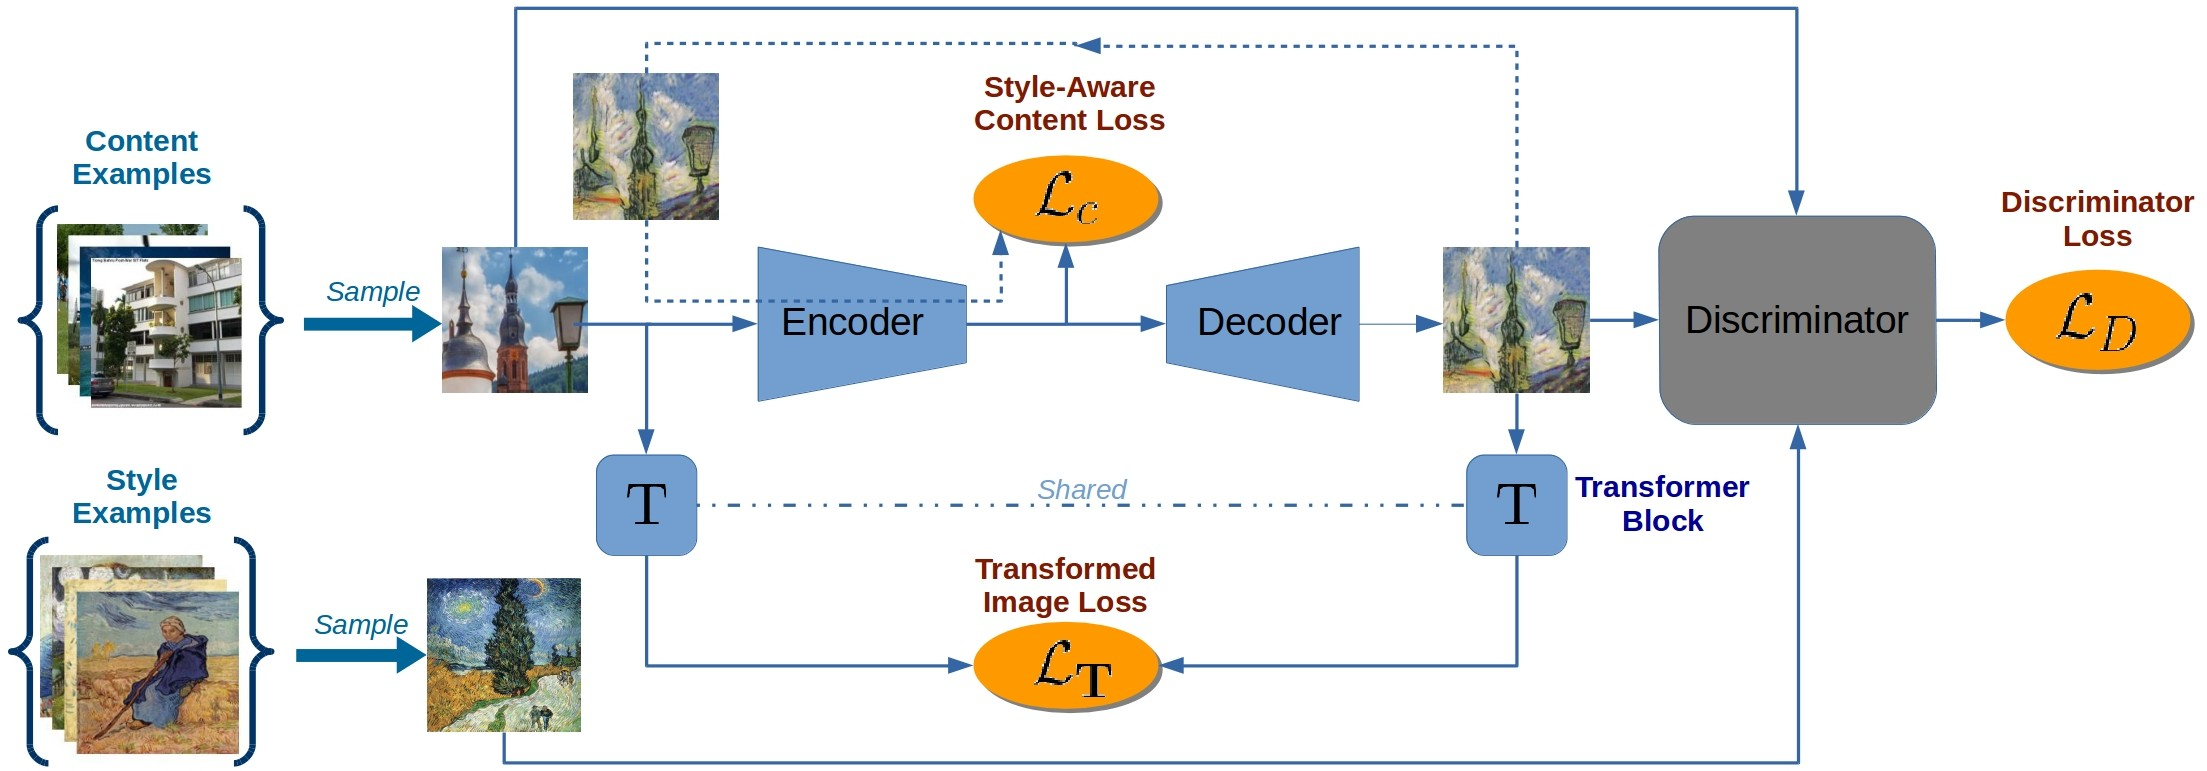
<center>Figure 1: Network architecture designed around style-aware loss (Sanakoyeu et al., 2018).</center>

Installing repo for style-based loss

In [ ]:
%%capture
!pip install gdown
!git clone https://github.com/CompVis/adaptive-style-transfer.git

Creating a new environment using python 3.6 (for compatibility)

In [ ]:
%%capture
!conda create -n venv -c cctbx202208 -y
!source /opt/conda/bin/activate venv && conda install -c cctbx202208 python=3.6 -y

Installing dependencies into new environment

In [ ]:
%%capture
!/opt/conda/envs/venv/bin/pip install tensorflow==1.12.0 pillow numpy==1.15.4 scipy==1.0.0 tqdm opencv-python==3.4.0.14

In [ ]:
!/opt/conda/envs/venv/bin/pip install pandas

In [ ]:
# Downloading a pre-trained model checkpoint
import gdown
gdown.download('https://drive.google.com/uc?id=1o6owJ42EKV-b02wUuUQsdAw4T9DR2QfJ', 'adaptive-style-transfer/models/model_monet_ckpt.tar.gz', quiet=False)

In [ ]:
!tar -zxvf /kaggle/working/adaptive-style-transfer/models/model_monet_ckpt.tar.gz -C /kaggle/working/adaptive-style-transfer/models/

In [ ]:
!mkdir  ../tmp

### 3.2 Inference

In [ ]:
%%sh
/opt/conda/envs/venv/bin/python3 adaptive-style-transfer/main.py \
                 --model_name=/kaggle/working/adaptive-style-transfer/models/model_monet \
                 --phase=inference \
                 --image_size=256 \
                 --ii_dir=/kaggle/input/gan-getting-started/photo_jpg \
                 --save_dir=/../tmp

# 4. Results and Analysis

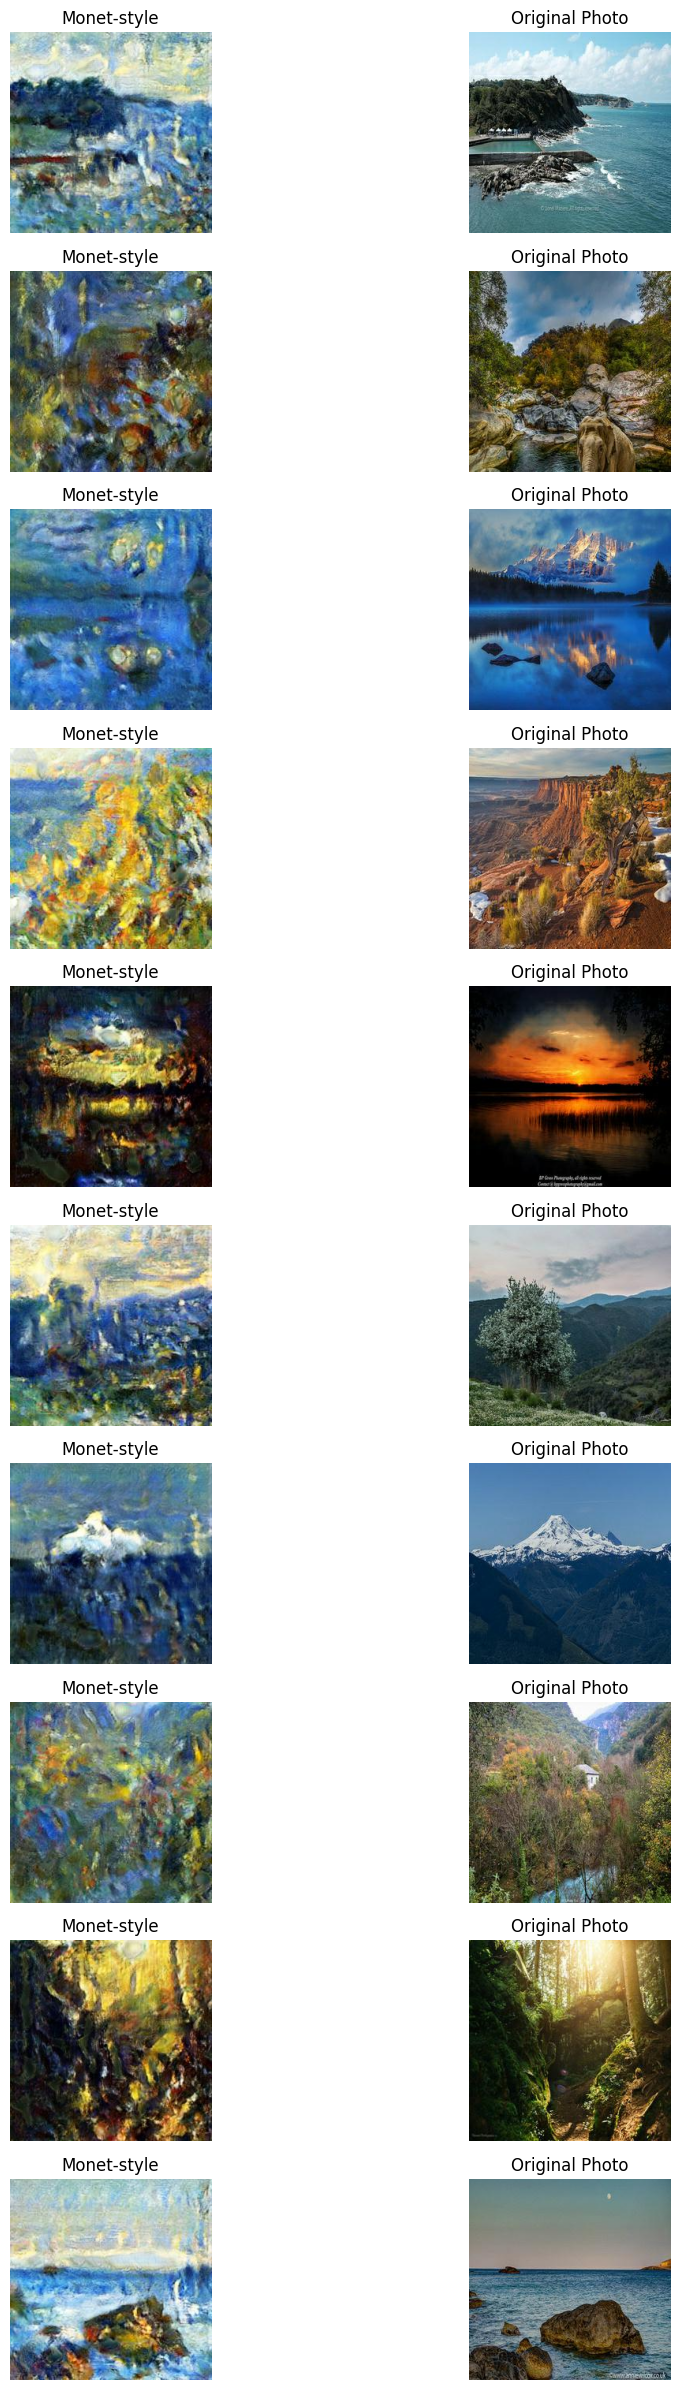

In [25]:
# Plotting stylized photos
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

stylized_dir = "/../tmp"
original_dir = "/kaggle/input/gan-getting-started/photo_jpg"


files = os.listdir(stylized_dir)

jpg_files = [file for file in files if file.endswith('.jpg')][20:30]

fig, axes = plt.subplots(10, 2, figsize=(12, 24))

for i, file in enumerate(jpg_files):
    stylized_img_path = os.path.join(stylized_dir, file)
    stylized_img = mpimg.imread(stylized_img_path)

    original_file = file.replace('_stylized', '')
    original_img_path = os.path.join(original_dir, original_file)
    original_img = mpimg.imread(original_img_path)

    axes[i, 0].imshow(stylized_img)
    axes[i, 0].set_title('Monet-style')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(original_img)
    axes[i, 1].set_title('Original Photo')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


Unfortunately, as FiD (which this is scored on) is a learned metric which we don't have access to outside of Kaggle submissions.

However visually, the generated images seem to do a good job of mapping Monet's visual style onto the photo images.

For comparison, here are results from the top scoring public notebook using a CycleGAN-based approach:

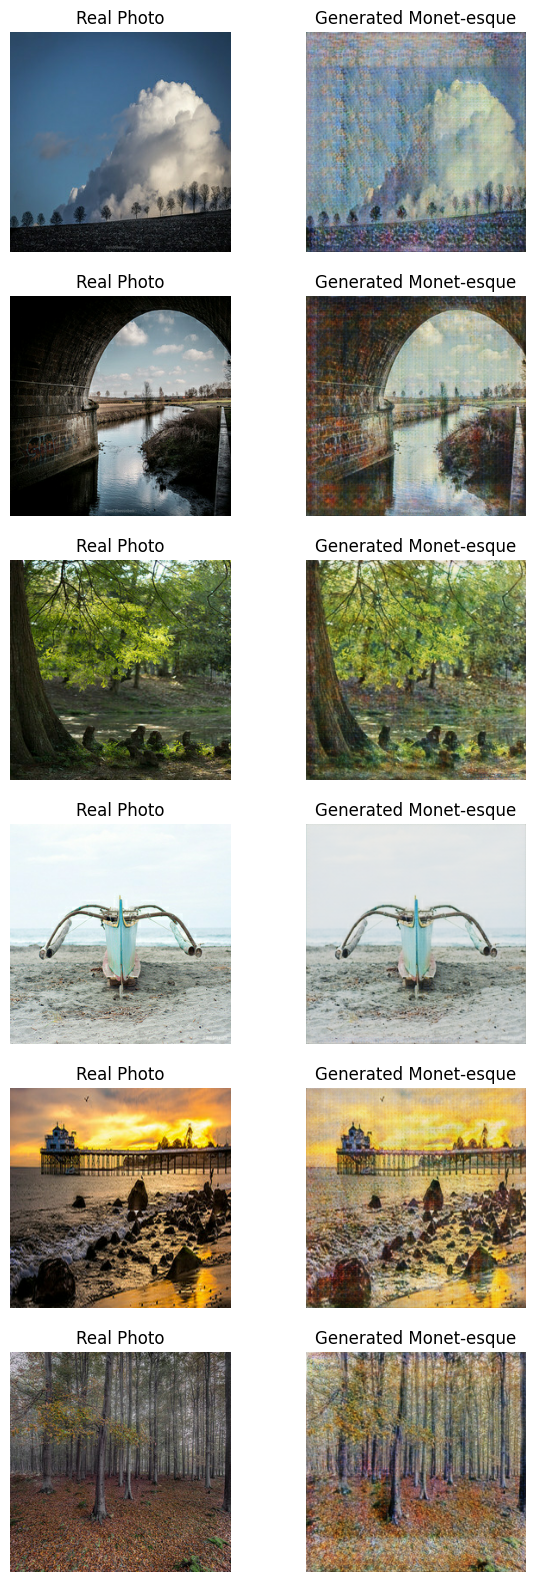
<center>(Hardik201003, 2024)</center>



As we can see, the style-aware approach I use applies Monet's style uniquely based on the image's content, while earlier cyclic-loss based approaches seem at apply a uniform change that doesn't vary much based on image content.

# 5. Conclusion
In conclusion, in this assignment I show the benefits of style-aware content loss and the impacts it can have on image-to-image translation. Namely, that a style-aware loss function results in a more interesting and robust style transfer that reflects the style of the artist uniquely with respect to the contents of the image being stylized.

# References

Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., ... & Bengio, Y. (2014). Generative adversarial nets. Advances in neural information processing systems, 27.

Hardik201003. (2024). CycleGAN | I'm Something of a Painter Myself. Retrieved from https://www.kaggle.com/code/hardik201003/cyclegan-i-m-something-of-a-painter-myself

Sanakoyeu, A., Kotovenko, D., Lang, S., & Ommer, B. (2018). A style-aware content loss for real-time hd style transfer. In proceedings of the European conference on computer vision (ECCV) (pp. 698-714).

Zhu, J. Y., Park, T., Isola, P., & Efros, A. A. (2017). Unpaired image-to-image translation using cycle-consistent adversarial networks. In Proceedings of the IEEE international conference on computer vision (pp. 2223-2232).